## Example 4: Quantum Phase Estimation

### Purpose

Quantum Phase Estimation (QPE) is an important part of many quantum algorithms, such as Shor's factorization algorithm. This example shows how QPE can be implemented with TinyQsim.

It demonstrates the following:

- How to implement QPE
- How to plot the probability distribution as a histogram
- How to create a custom controlled gate
- An application of the QFT developed in example 3

We will start by importing the libraries that we need and the inverse QFT from example 3.

In [1]:
PI = '\u03C0'  # Unicode pi
PHI = '\u03d5'  # Unicode phi
from math import pi

import numpy as np

from tinyqsim.qcircuit import QCircuit

In [2]:
def iqft(qc, n: int, start: int = 0):
    """ N-qubit inverse QFT starting at qubit index 'start'."""
    for i in range(n // 2 - 1, -1, -1):  # Reverse order of qubits
        qc.swap(start + i, start + n - i - 1)
    for i in range(n - 1, -1, -1):
        j = i + start
        for k in range(n - i - 1, 0, -1):
            qc.cp(-pi / 2 ** k, f'-{PI}/{2 ** k}', j, j + k)
        qc.h(j)

### Introduction

Any unitary operator can be expressed in terms of the phases of its eigenvectors:

$$\qquad U=\sum_k{e^{i\theta_k}\,\ket{\psi_k}\bra{\psi_k}}$$

where $\lambda_k = e^{i\theta_k}$ are the corresponding eigenvalues.

The eigenvalue always has a magnitude of one because the operator is unitary.

If we apply the unitary to one of its eigenvectors $\ket{\psi_k}$, the result will be the corresponding eigenvalue $e^{i\theta_k}$ multiplied by the eigenstate:

$$\qquad\begin{align*}
U \ket{\psi_k} &= ({e^{i\theta_k}\,\ket{\psi_k}\bra{\psi_k}})\ \ket{\psi_k}\\
&= e^{i\theta_k}\ket{\psi_k}
\end{align*}$$

The aim of QPE is to find the phase associated with an eigenvector $\ket{\psi}$ of a unitary $U$.

The QPE algorithm works by expressing the phase as a binary fraction $\,\phi\in[0,1]$ so that it can be approximated to the required precision one bit at a time:

$$\quad\phi=\sum_{k=1}^n{\phi_k} 2^{-k} = 0.\phi_1\phi_2\dots\phi_n$$

where $\phi_k\in\{0,1\}$ and .' denotes the *binary point* analogous to a decimal point.

The symbol $\theta$ was used above for the phase in radians to avoid confusion.

### Simple 1-qubit Phase Register

Let us start with the simplest case of a one-bit binary estimation.

In [3]:
def qpe1(qc, phi):
    """ QPE for 1-qubit unitary using 1-qubit phase register."""
    qc.barrier()
    qc.h(0)
    qc.cp(2 * pi * phi, f'{PHI}={phi}', 0, 1)
    qc.h(0)

We will first run the circuit with $\phi=0$:

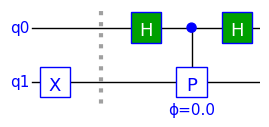

In [4]:
phi = 0 / 2
qc = QCircuit(2)
qc.x(1)
qpe1(qc, phi)
qc.draw()

The X gate initializes qubit 1 to $\ket{1}$, which is the eigenvector of the unitary P for which we want to find $\phi$. The barrier symbol is simply to separate the initialization from the actual QPE algorithm.

The input phase was 0, resulting in the output state $\ket{0}$ as shown by the histogram:

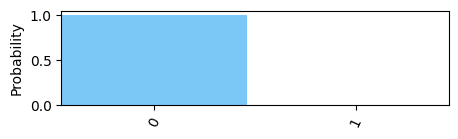

In [5]:
qc.plot_probabilities(0)

If we repeat the run with $\phi=\frac{1}{2}$, the output state is $\ket{1}$:

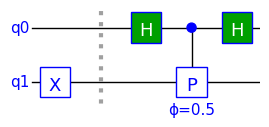

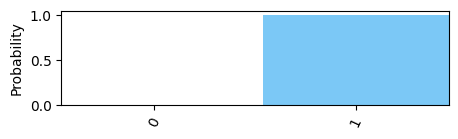

In [6]:
phi = 1 / 2
qc = QCircuit(2)
qc.x(1)  # q1 = |1>
qpe1(qc, phi)
qc.draw()
qc.plot_probabilities(0)

A binary point must be placed before the result of 0 or 1 to express it as a binary fraction.

The X gate gives qubit 1 an initial state of $\ket{1}$, which is an eigenstate of the phase gate we are trying to measure. The *phase kickback* effect kicks the phase of the phase gate back to the control qubit q0. The first Hadamard (H) gate places qubit 0 in the superposition state $\ket{+}$ by effectively transforming between the Z and X bases. The second Hadamard gate would simply undo the effect of the first one if there were no phase kickback to q0. However, with the phase kickback, the second Hadamard transforms the phase back to the Z-basis, resulting in a change in the probability of measuring $\ket{0}$ or $\ket{1}$. The second Hadamard is actually performing an inverse Quantum Fourier transform (QFT), but in the trivial case of one qubit this reduces to the Hadamard operator.

### QPE Algorithm with a 2-qubit Phase Register

To improve the accuracy, we need to add more qubits, each calculating the next bit in the binary expansion of the phase.

In [7]:
def qpe2(qc, phi):
    """ QPE for 1-qubit unitary using 2-qubit phase register."""
    radians = 2 * pi * phi
    qc.barrier()
    qc.h([0,1])
    qc.cp(radians, 'phi', 1, 2)
    qc.cp(radians, 'phi', 0, 2)
    qc.cp(radians, 'phi', 0, 2)
    qc.barrier()
    iqft(qc, 2, start=0)

We will create an instance with a unitary that has a phase $\phi=\frac{1}{4}$.

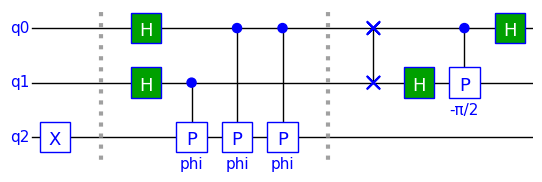

In [8]:
phi = 1 / 4
qc = QCircuit(3)
qc.x(2)  # q2 = |1>
qpe2(qc, phi)
qc.draw()

The part of the circuit to the right of the second barrier is an inverese 2-qubit QFT to change the basis.

We can plot the probabilities as a histogram.

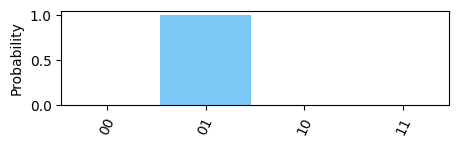

In [9]:
qc.plot_probabilities(*range(2))

The resulting state is $\ket{01}$. We place a binary point before the '01' giving the binary fraction $0.01_2$ which is the value $\phi=\frac{1}{4}$ expressed in binary.

We can repeat the experiment for $\phi=\frac{3}{4}$:

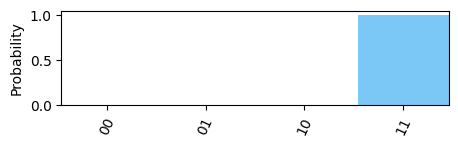

In [10]:
phi = 3 / 4
qc = QCircuit(3)
qc.x(2)
qpe2(qc, phi)
qc.plot_probabilities(*range(2))

The result is $0.11_2$ in binary as the phase to be found was $\frac{3}{4}$.

We can improve the phase resolution by measuring more binary bits.

### Generalizing to an K-qubit Phase Register

We can generalize the algorithm to 'k' qubits by using Python code to generate the circuit, as we we did with QFT in example 3.

In [11]:
def qpe(qc, k, phi):
    """ QPE for 1-qubit unitary using k-qubit phase register."""
    radians = 2 * pi * phi
    qc.barrier()
    qc.h(range(k))
    for q in range(k):
        i = k - q - 1
        for j in range(2 ** q):
            qc.cp(radians, 'phi', i, k)
    qc.barrier()
    iqft(qc, k, start=0)

We will create an instance for $k=4$ with a unitary that has a phase of $2\pi\times \frac{11}{16}$ :

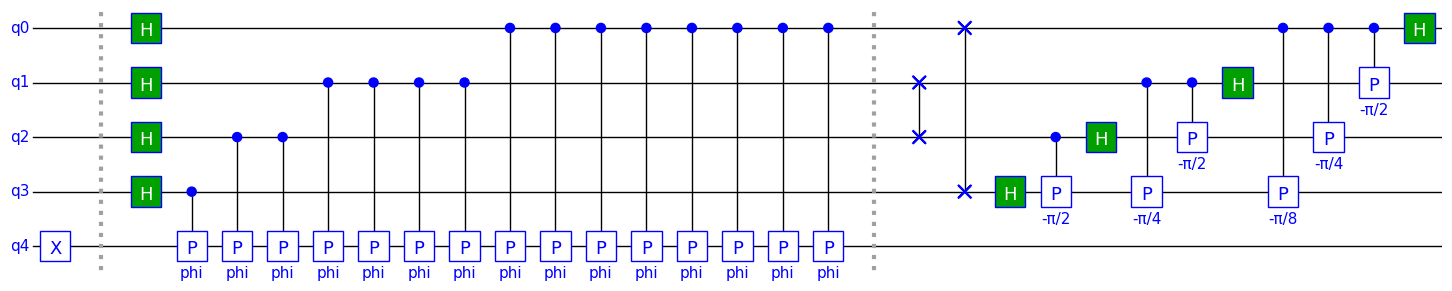

In [12]:
k = 4
phi = 11 / 2 ** k
qc = QCircuit(k + 1)
qc.x(k)
qpe(qc, k, phi)
qc.draw()

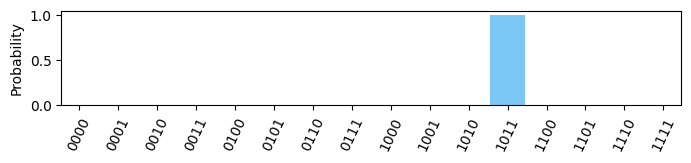

In [13]:
qc.plot_probabilities(*range(k))

The result is $\phi=0.1011_2$ which is $\frac{11}{16}$.

Finally, let us set the phase to half way between resolution steps:

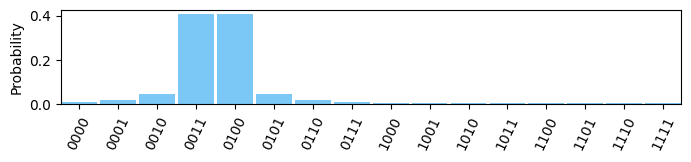

In [14]:
k = 4
phi = 3.5 / 2 ** k
qc = QCircuit(k + 1)
qc.x(k)
qpe(qc, k, phi)
qc.plot_probabilities(*range(k))

Phi has equal probabilities for 0011 and 0100 because the actual value is mid-way between them, e.g. 0.00111 (base 2).

### Custom Unitary

Let us define a custom unitary 'u' and modify the the QPE circuit to use it.

In [15]:
def u(phi):
    return np.array([[1, 0], [0, np.exp(1j * 2 * pi * phi)]])

In [16]:
def qpe_u(qc, k, u):
    """ QPE for 1-qubit unitary using k-qubit phase register."""
    qc.barrier()
    for q in range(k):
        qc.h(k - q - 1)

    for q in range(k):
        i = k - q - 1
        for j in range(2 ** q):
            qc.cu(u, 'U', i, k)
    qc.barrier()
    iqft(qc, k, start=0)

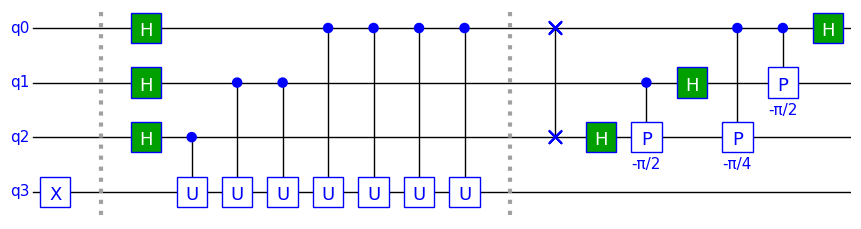

In [17]:
k = 3
phi = 3 / 2 ** k
qc = QCircuit(k + 1)
qc.x(k)
qpe_u(qc, k, u(phi))
qc.draw()

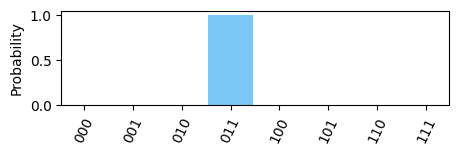

In [18]:
qc.plot_probabilities(*range(k))

The estimated phase is $0.011_2$ or $\frac{3}{8}$.